# ⚡️ Energy Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the EBM](#build)
3. [Train the EBM](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import datasets

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from utils.image import display
import random

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 0. Parameters <a name="parameters"></a>

In [153]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 10
NOISE = 0.0005
ALPHA = 0.1
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS = 300

In [154]:
# Load the data
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

In [155]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs , ((0,0), (2,2), (2,2)), constant_values= -1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)

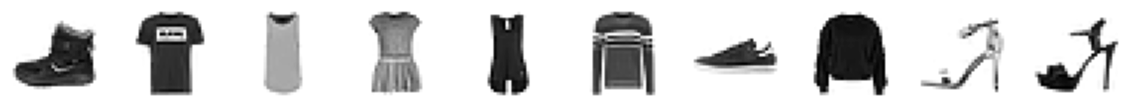

In [156]:
# Show some items of clothing from the training set
display(x_train)

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})## 2. Build the EBM network <a name="build"></a>

In [166]:
ebm_input = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation = keras.activations.swish)(ebm_input)
x = keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation = keras.activations.swish)(x)
x = keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation = keras.activations.swish)(x)
x = keras.layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
ebm_output =  keras.layers.Flatten()(x)
ebm_model = keras.Model(ebm_input, ebm_output)
ebm_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 128)       2176      
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 conv2d_42 (Conv2D)          (None, 4, 4, 128)         262272    
                                                                 
 conv2d_43 (Conv2D)          (None, 1, 1, 1)           2049      
                                                                 
 flatten_10 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 528,769
Trainable params: 528,769
Non-traina

In [167]:
class Sampler:
    def __init__(self, model, max_len=BUFFER_SIZE):
        super().__init__()
        self.model = model
        self.max_len = max_len
        self.examples = [tf.random.uniform(shape = (1, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1 for _ in range(BATCH_SIZE)]
                         
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        old_imgs = tf.concat(random.choices(self.examples, k=BATCH_SIZE-n_new), axis=0)
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = self.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size, noise = noise)
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis = 0) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
        imgs_per_step = []
        for _ in range(steps):
            inp_imgs += tf.random.normal(inp_imgs.shape, mean = 0, stddev = noise)
            inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
            with tf.GradientTape() as tape:
                tape.watch(inp_imgs)
                out_score = model(inp_imgs)
            # print('Score = ', np.mean(out_score))
            grads = tape.gradient(out_score, inp_imgs)
            # print('Grads = ', np.mean(grads))
            grads = tf.clip_by_value(grads, -0.03, 0.03)
            inp_imgs += step_size * grads
            # print('Step = ', np.mean(step_size * grads))
            # print()
            inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
            if return_img_per_step:
                imgs_per_step.append(inp_imgs)
        if return_img_per_step:
            return tf.stack(imgs_per_step, axis=0)
        else:
            return inp_imgs

In [168]:
class EBM(keras.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.cnn = ebm_model
        self.sampler = Sampler(self.cnn)
        self.alpha = ALPHA
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.reg_loss_metric = keras.metrics.Mean(name="reg")
        self.cdiv_loss_metric = keras.metrics.Mean(name="cdiv")
        self.real_out_metric = keras.metrics.Mean(name="real")
        self.fake_out_metric = keras.metrics.Mean(name="fake")
       
    @property
    def metrics(self):
        return [self.loss_metric, self.reg_loss_metric, self.cdiv_loss_metric, self.real_out_metric, self.fake_out_metric]
    
    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean = 0, stddev = NOISE)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.sampler.sample_new_exmps(steps=STEPS, step_size=STEP_SIZE, noise = NOISE)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.cnn(inp_imgs), 2, axis=0)
            reg_loss = self.alpha * tf.reduce_mean(real_out ** 2 + fake_out ** 2, axis = 0)
            cdiv_loss = tf.reduce_mean(fake_out, axis = 0) - tf.reduce_mean(real_out, axis = 0)
            loss = reg_loss + cdiv_loss
        grads = training_tape.gradient(loss, self.cnn.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.cnn.trainable_variables))
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))
        return {m.name: m.result() for m in self.metrics}

In [169]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [170]:
# Compile and train the model
ebm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), run_eagerly=True)

In [171]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

In [172]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [173]:
class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = np.random.uniform(size = (self.num_img,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1
        generated_images = Sampler.generate_samples(ebm.cnn, start_imgs, steps=200, step_size=STEP_SIZE, noise = NOISE, return_img_per_step=False)
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        

Epoch 1/300
469/469 [==============================] - ETA: 0s - loss: -0.1868 - reg: 0.1229 - cdiv: -0.3097 - real: 0.4644 - fake: 0.1546
Saved to ./output/generated_img_000.png


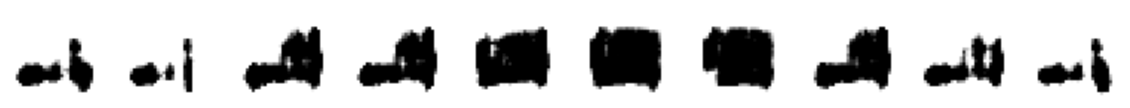

469/469 [==============================] - 87s 186ms/step - loss: -0.1868 - reg: 0.1229 - cdiv: -0.3097 - real: 0.4644 - fake: 0.1546
Epoch 2/300
469/469 [==============================] - ETA: 0s - loss: -0.0458 - reg: 0.0351 - cdiv: -0.0810 - real: 0.0492 - fake: -0.0318
Saved to ./output/generated_img_001.png


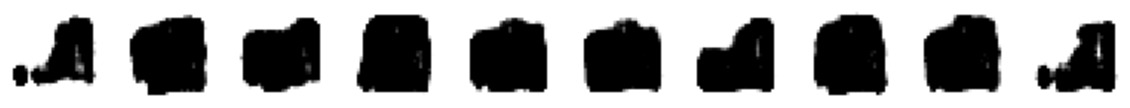

469/469 [==============================] - 86s 183ms/step - loss: -0.0458 - reg: 0.0351 - cdiv: -0.0810 - real: 0.0492 - fake: -0.0318
Epoch 3/300
469/469 [==============================] - ETA: 0s - loss: -0.0296 - reg: 0.0307 - cdiv: -0.0603 - real: 0.0358 - fake: -0.0245
Saved to ./output/generated_img_002.png


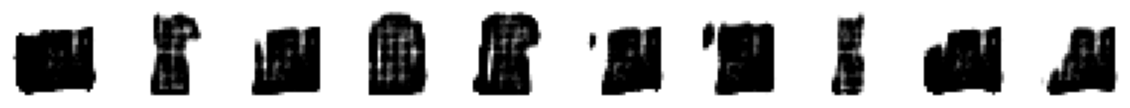

469/469 [==============================] - 85s 182ms/step - loss: -0.0296 - reg: 0.0307 - cdiv: -0.0603 - real: 0.0358 - fake: -0.0245
Epoch 4/300
469/469 [==============================] - ETA: 0s - loss: -0.0189 - reg: 0.0235 - cdiv: -0.0424 - real: 0.0234 - fake: -0.0190
Saved to ./output/generated_img_003.png


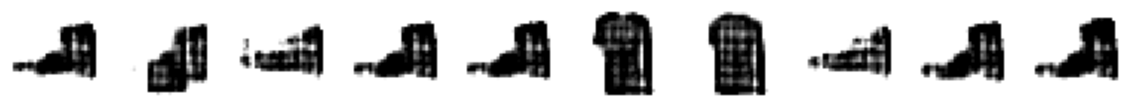

469/469 [==============================] - 86s 183ms/step - loss: -0.0189 - reg: 0.0235 - cdiv: -0.0424 - real: 0.0234 - fake: -0.0190
Epoch 5/300
469/469 [==============================] - ETA: 0s - loss: -0.0162 - reg: 0.0219 - cdiv: -0.0382 - real: 0.0214 - fake: -0.0167
Saved to ./output/generated_img_004.png


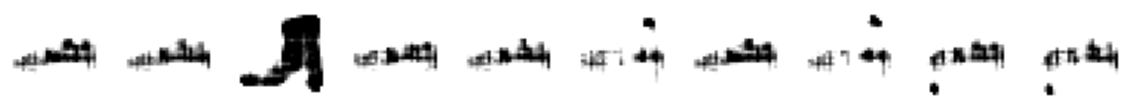

469/469 [==============================] - 85s 182ms/step - loss: -0.0162 - reg: 0.0219 - cdiv: -0.0382 - real: 0.0214 - fake: -0.0167
Epoch 6/300
469/469 [==============================] - ETA: 0s - loss: -0.0149 - reg: 0.0194 - cdiv: -0.0344 - real: 0.0193 - fake: -0.0150
Saved to ./output/generated_img_005.png


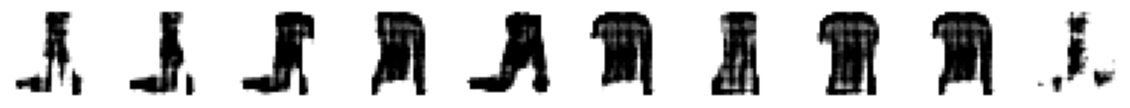

469/469 [==============================] - 86s 182ms/step - loss: -0.0149 - reg: 0.0194 - cdiv: -0.0344 - real: 0.0193 - fake: -0.0150
Epoch 7/300
469/469 [==============================] - ETA: 0s - loss: -0.0132 - reg: 0.0187 - cdiv: -0.0319 - real: 0.0167 - fake: -0.0152
Saved to ./output/generated_img_006.png


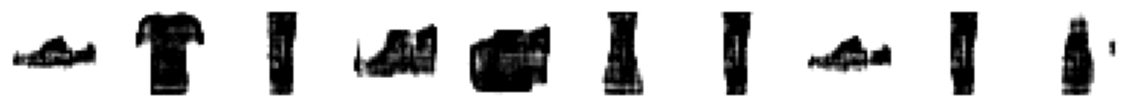

469/469 [==============================] - 86s 182ms/step - loss: -0.0132 - reg: 0.0187 - cdiv: -0.0319 - real: 0.0167 - fake: -0.0152
Epoch 8/300
469/469 [==============================] - ETA: 0s - loss: -0.0138 - reg: 0.0188 - cdiv: -0.0325 - real: 0.0178 - fake: -0.0148
Saved to ./output/generated_img_007.png


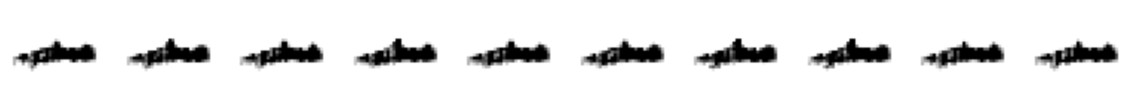

469/469 [==============================] - 87s 185ms/step - loss: -0.0138 - reg: 0.0188 - cdiv: -0.0325 - real: 0.0178 - fake: -0.0148
Epoch 9/300
469/469 [==============================] - ETA: 0s - loss: -0.0136 - reg: 0.0194 - cdiv: -0.0330 - real: 0.0174 - fake: -0.0156
Saved to ./output/generated_img_008.png


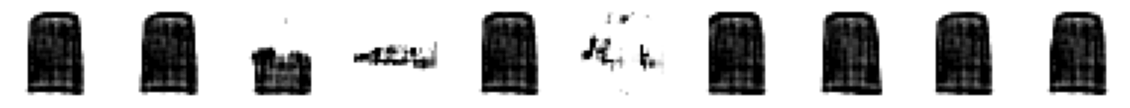

469/469 [==============================] - 86s 182ms/step - loss: -0.0136 - reg: 0.0194 - cdiv: -0.0330 - real: 0.0174 - fake: -0.0156
Epoch 10/300
469/469 [==============================] - ETA: 0s - loss: -0.0101 - reg: 0.0169 - cdiv: -0.0270 - real: 0.0138 - fake: -0.0132
Saved to ./output/generated_img_009.png


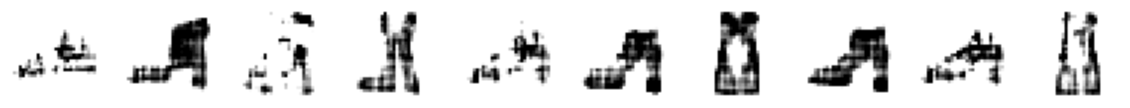

469/469 [==============================] - 85s 182ms/step - loss: -0.0101 - reg: 0.0169 - cdiv: -0.0270 - real: 0.0138 - fake: -0.0132
Epoch 11/300
469/469 [==============================] - ETA: 0s - loss: -0.0107 - reg: 0.0167 - cdiv: -0.0274 - real: 0.0154 - fake: -0.0120
Saved to ./output/generated_img_010.png


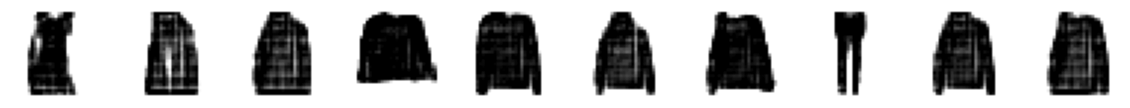

469/469 [==============================] - 86s 182ms/step - loss: -0.0107 - reg: 0.0167 - cdiv: -0.0274 - real: 0.0154 - fake: -0.0120
Epoch 12/300
469/469 [==============================] - ETA: 0s - loss: -0.0121 - reg: 0.0168 - cdiv: -0.0289 - real: 0.0148 - fake: -0.0141
Saved to ./output/generated_img_011.png


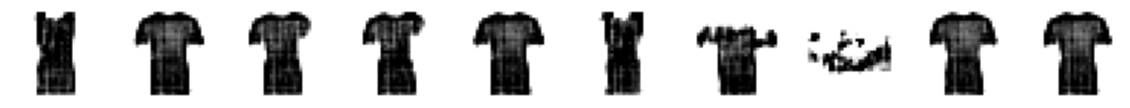

469/469 [==============================] - 86s 182ms/step - loss: -0.0121 - reg: 0.0168 - cdiv: -0.0289 - real: 0.0148 - fake: -0.0141
Epoch 13/300
207/469 [============>.................] - ETA: 45s - loss: -0.0121 - reg: 0.0177 - cdiv: -0.0298 - real: 0.0163 - fake: -0.0135

KeyboardInterrupt: 

In [174]:
ebm.fit(
    # np.array([x_train[0] for _ in range(5000)] + [x_train[1] for _ in range(5000)])
    x_train
    , batch_size=BATCH_SIZE
    , shuffle = True
    , epochs=EPOCHS
    , callbacks = [model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10)]
)

## 4. Generate images <a name="generate"></a>

In [250]:
start_imgs = np.random.uniform(size = (10,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1

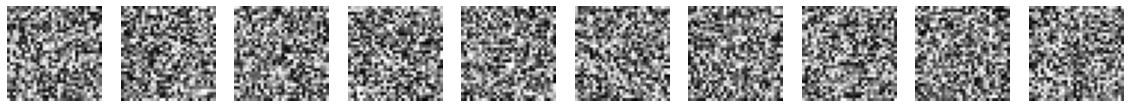

In [251]:
display(start_imgs)

In [252]:
gen_img = Sampler.generate_samples(ebm.cnn, start_imgs, steps=200, step_size=10, noise = 0.005, return_img_per_step=False)

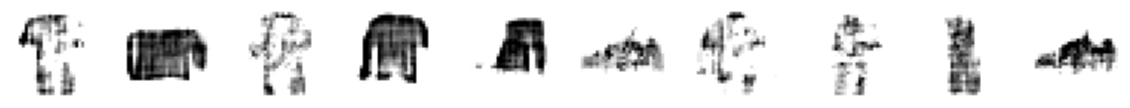

In [253]:
display(gen_img.numpy())